In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def process_solve_status(s):
    if s == "Infeasible" or s == "Unbounded" or s == "InfeasibleOrUnbounded":
        return "ProvablyRobustByClass"
    elif s == "InfeasibleDistance":
        return "ProvablyRobustByDistance"
    elif s.startswith("InfeasibleDistance"):
        min_threshold = float(s[18:])
        return min_threshold
    elif s.startswith("InfeasibleUndecidedDistance"):
        min_threshold = float(s[27:])
        return min_threshold
    elif s == "UserLimit":
        return "StatusUnknown"
    else:
        return "Vulnerable"

In [3]:
def count_while(arr, pred, index = 0):
    count = 0
    while count + index < len(arr) and pred(arr[count + index]):
        count += 1
    return count
        

def get_accuracies(filename):
    dt = pd.read_csv(filename)
    dt = dt.drop_duplicates(subset = "SampleNumber", keep="last")
    dt["ProcessedSolveStatus"] = dt["SolveStatus"].apply(process_solve_status)
    
    adv_results = dt.groupby("ProcessedSolveStatus")["SampleNumber"].count().to_dict()
    cumulative_adv_results = []
    accumulator = adv_results["ProvablyRobustByClass"]
    for i in range(-24, 41):
        if (i / 10) in adv_results:
            accumulator += adv_results[i / 10]
        cumulative_adv_results.append(accumulator)
    
    nat_results = sorted(dt["NaturalInputMinDistance"].values)
    cumulative_nat_results = []
    accumulator = 0
    for i in range(-24, 41):
        accumulator += count_while(nat_results, lambda x: x < i / 10, accumulator)
        cumulative_nat_results.append(accumulator)
    
    return((1 - np.asarray(cumulative_nat_results) / len(nat_results)),
        (np.asarray(cumulative_adv_results) / sum(adv_results.values())))

0.9914 0.9744
Maximise nat and adv accuracy at epsilon =  0.6
Nat accuracy 0.9824
Adv accuracy 0.9824 

0.9778 0.9296
Maximise nat and adv accuracy at epsilon =  0.5
Nat accuracy 0.942
Adv accuracy 0.94 

0.9728 0.8268
Maximise nat and adv accuracy at epsilon =  1.4
Nat accuracy 0.8868
Adv accuracy 0.8828 



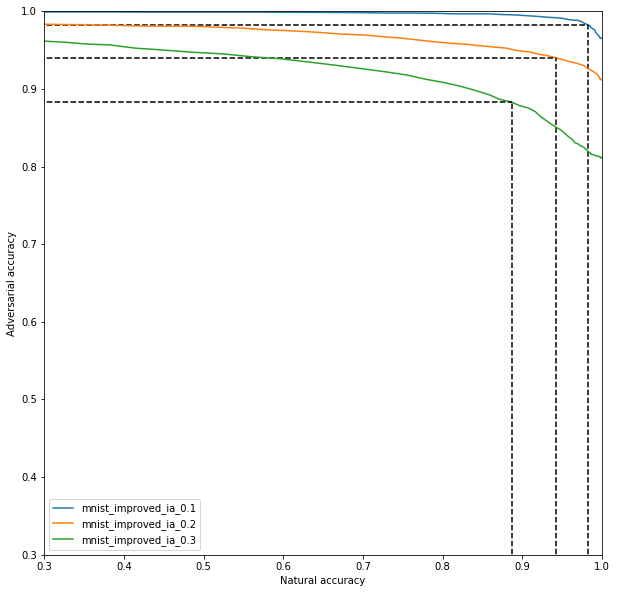

In [4]:
plt.figure(figsize=(10,10))

for dataset in ["mnist_improved_ia_0.1__linf-norm-bounded-0.1__Inf__0.0",
                "mnist_improved_ia_0.2__linf-norm-bounded-0.2__Inf__0.0",
                "mnist_improved_ia_0.3__linf-norm-bounded-0.3__Inf__0.0"]:

    filename = "verification/results_validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies(filename)
    plt.plot(nat_accuracies, adv_accuracies, label=dataset[:21])
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")
    
    print(nat_accuracies[24], adv_accuracies[24])

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at epsilon = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")
    
    plt.plot((nat_acc, nat_acc), (0, adv_acc), "k--")
    plt.plot((0, nat_acc), (adv_acc, adv_acc), "k--")

plt.axis([0.3,1,0.3,1])
plt.legend()
plt.show()

In [5]:
mnist_test_labels = pd.read_csv("parser/mnist_test_labels.csv").set_index("SampleNumber")

def get_accuracies_test(filename, threshold):
    dt = pd.read_csv(filename)
    dt.SampleNumber -=1
    dt.PredictedIndex -=1
    dt = dt.drop_duplicates(
        subset = "SampleNumber", keep="last"
    ).set_index("SampleNumber").sort_index().join(mnist_test_labels)
    
    nat_results = np.logical_and(dt["NaturalInputMinDistance"].values >= threshold,
                                 (dt.PredictedIndex == dt.TrueIndex).values).sum()

    dt["ProcessedSolveStatus"] = dt["SolveStatus"].apply(process_solve_status)
    adv_results = dt.groupby("ProcessedSolveStatus")["PredictedIndex"].count().to_dict()
    
    return (nat_results / dt["PredictedIndex"].count(),
            (adv_results["ProvablyRobustByClass"]
             + adv_results["ProvablyRobustByDistance"]) / dt["PredictedIndex"].count())

In [6]:
for dataset, threshold in [("mnist_improved_ia_0.1__linf-norm-bounded-0.1__Inf__0.0", 0.6),
                           ("mnist_improved_ia_0.2__linf-norm-bounded-0.2__Inf__0.0", 0.5),
                           ("mnist_improved_ia_0.3__linf-norm-bounded-0.3__Inf__0.0", 1.4)]:

    filename = "verification/results_test/" + dataset + "/summary.csv"
    nat_acc, adv_acc = get_accuracies_test(filename, threshold)
    
    print(dataset[:21], "with distance threshold", threshold)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")

mnist_improved_ia_0.1 with distance threshold 0.6
Nat accuracy 0.9621
Adv accuracy 0.9684 

mnist_improved_ia_0.2 with distance threshold 0.5
Nat accuracy 0.924
Adv accuracy 0.933 

mnist_improved_ia_0.3 with distance threshold 1.4
Nat accuracy 0.8609
Adv accuracy 0.8822 

